<a href="https://colab.research.google.com/github/Nickchiu120026/2025_machine_learning/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pathlib import Path

# 1) 如果檔案已經在當前資料夾，先檢查一次
!ls -lah

XML_FILE = "O-A0038-003.xml"
if not Path(XML_FILE).exists():
    print("\n⚠️ 找不到 O-A0038-003.xml，請在彈窗中選擇檔案上傳...")
    from google.colab import files
    uploaded = files.upload()  # 會跳出選檔視窗
    # 自動抓第一個上傳檔名
    XML_FILE = next(iter(uploaded))
    print("✅ 已偵測上傳的檔案：", XML_FILE)

# 2) 把你的讀檔函式改成接受路徑參數（若還沒改）
#    例如：data = load_grid_from_xml(XML_FILE)


total 16K
drwxr-xr-x 1 root root 4.0K Sep 26 13:39 .
drwxr-xr-x 1 root root 4.0K Sep 30 15:03 ..
drwxr-xr-x 4 root root 4.0K Sep 26 13:39 .config
drwxr-xr-x 1 root root 4.0K Sep 26 13:40 sample_data

⚠️ 找不到 O-A0038-003.xml，請在彈窗中選擇檔案上傳...


Saving O-A0038-003.xml to O-A0038-003.xml
✅ 已偵測上傳的檔案： O-A0038-003.xml


[Epoch 100] Cls Train=0.0635 | Cls Val=0.0562
[Epoch 200] Cls Train=0.0522 | Cls Val=0.0525
[Epoch 300] Cls Train=0.0501 | Cls Val=0.0623
[Epoch 400] Cls Train=0.0406 | Cls Val=0.0393
[Epoch 500] Cls Train=0.0509 | Cls Val=0.0534
[Epoch 600] Cls Train=0.0385 | Cls Val=0.0448
[Epoch 700] Cls Train=0.0314 | Cls Val=0.0394
[Epoch 800] Cls Train=0.0339 | Cls Val=0.0408
[Epoch 900] Cls Train=0.0309 | Cls Val=0.0416
[Epoch 1000] Cls Train=0.0344 | Cls Val=0.0388


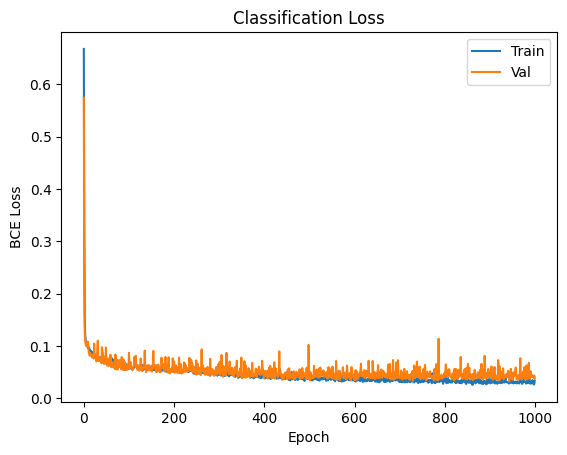

[Epoch 100] Reg Train=37.5793 | Reg Val=38.3651
[Epoch 200] Reg Train=37.5590 | Reg Val=38.4884
[Epoch 300] Reg Train=37.5580 | Reg Val=38.4945
[Epoch 400] Reg Train=9.0932 | Reg Val=9.4371
[Epoch 500] Reg Train=7.1878 | Reg Val=7.2708
[Epoch 600] Reg Train=6.6558 | Reg Val=7.3239
[Epoch 700] Reg Train=6.5994 | Reg Val=6.8037
[Epoch 800] Reg Train=6.2381 | Reg Val=6.4648
[Epoch 900] Reg Train=6.0144 | Reg Val=6.4148
[Epoch 1000] Reg Train=5.9608 | Reg Val=6.3036


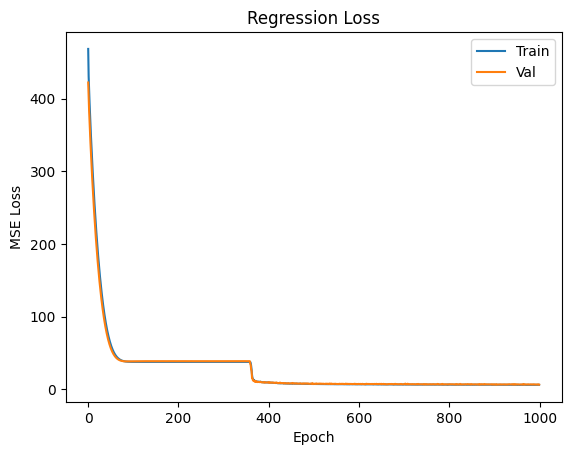

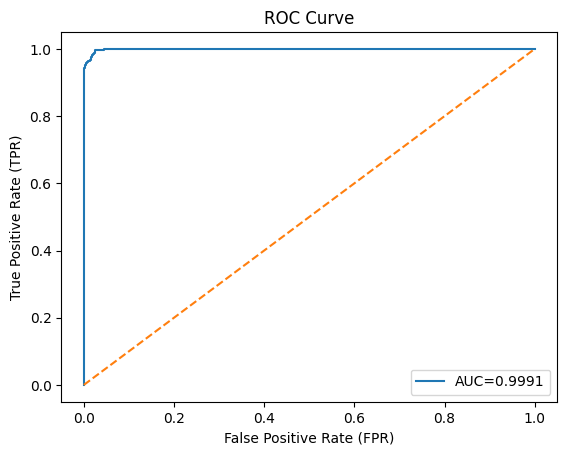


[Classification]  {'AUC': np.float64(0.9991114512120312), 'ACC': 0.9807213930348259, 'F1': 0.9773887673231219}


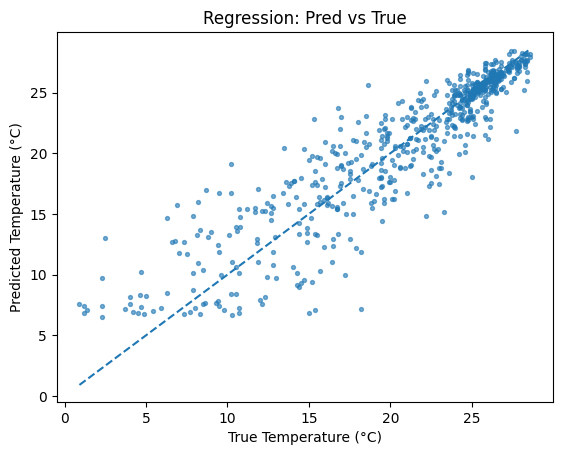

[Regression]      {'RMSE': 2.5106891995940095, 'MAE': 1.6774210929870605, 'R2': 0.8350934386253357}


In [6]:
from pathlib import Path
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import random, math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score
)


XML_FILE = "O-A0038-003.xml"
if not Path(XML_FILE).exists():
    print("⚠️ 找不到 O-A0038-003.xml，請在彈窗中選擇檔案上傳…")
    from google.colab import files
    uploaded = files.upload()
    XML_FILE = next(iter(uploaded))
    print("✅ 已上傳：", XML_FILE)


NS = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
DLON, DLAT = 0.03, 0.03
COLS, ROWS = 67, 120
MISSING = -999.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
EPOCHS = 1000
LR = 1e-3
BATCH = 64

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)


def load_grid_from_xml(path):
    assert os.path.exists(path), f"找不到檔案：{path}"
    tree = ET.parse(path)
    root = tree.getroot()

    lon0 = float(root.find('.//cwa:BottomLeftLongitude', NS).text)
    lat0 = float(root.find('.//cwa:BottomLeftLatitude', NS).text)

    content_text = root.find('.//cwa:Content', NS).text.strip()
    values = [float(v) for v in content_text.replace('\n', ',').split(',') if v.strip()]
    assert len(values) == ROWS*COLS, f"值數量錯誤：{len(values)}"

    grid = np.array(values, dtype=np.float32).reshape(ROWS, COLS)

    # 建座標 + 正規化
    lon = np.linspace(lon0, lon0 + (COLS-1)*DLON, COLS)
    lat = np.linspace(lat0, lat0 + (ROWS-1)*DLAT, ROWS)
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    lon_norm = (lon_mesh - lon.min()) / (lon.max() - lon.min())
    lat_norm = (lat_mesh - lat.min()) / (lat.max() - lat.min())

    label_grid = (grid != MISSING).astype(np.float32)
    value_grid = np.where(grid == MISSING, np.nan, grid).astype(np.float32)

    return {
        "lon": lon, "lat": lat,
        "lon_norm": lon_norm, "lat_norm": lat_norm,
        "label_grid": label_grid, "value_grid": value_grid
    }


def make_classification_loaders(data, split=0.8):
    X = np.stack([data["lon_norm"].ravel(), data["lat_norm"].ravel()], axis=1).astype(np.float32)
    y = data["label_grid"].ravel().astype(np.float32)[:, None]
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    n_tr = int(len(ds)*split); n_va = len(ds)-n_tr
    tr, va = random_split(ds, [n_tr, n_va], generator=torch.Generator().manual_seed(SEED))
    return DataLoader(tr, batch_size=BATCH, shuffle=True), DataLoader(va, batch_size=BATCH)

def make_regression_loaders(data, split=0.8):
    mask = ~np.isnan(data["value_grid"].ravel())
    X = np.stack([data["lon_norm"].ravel()[mask], data["lat_norm"].ravel()[mask]], axis=1).astype(np.float32)
    y = data["value_grid"].ravel()[mask].astype(np.float32)[:, None]
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    n_tr = int(len(ds)*split); n_va = len(ds)-n_tr
    tr, va = random_split(ds, [n_tr, n_va], generator=torch.Generator().manual_seed(SEED))
    return DataLoader(tr, batch_size=BATCH, shuffle=True), DataLoader(va, batch_size=BATCH)


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,32), nn.ReLU(),
            nn.Linear(32,8),  nn.ReLU(),
            nn.Linear(8,1),   nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64), nn.Tanh(),
            nn.Linear(64,64), nn.Tanh(),
            nn.Linear(64,32), nn.Tanh(),
            nn.Linear(32,8),  nn.Tanh(),
            nn.Linear(8,1)
        )
    def forward(self, x): return self.net(x)


def train_cls(model, tr_loader, va_loader):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.BCELoss()

    tr_hist, va_hist = [], []
    for ep in range(1, EPOCHS+1):
        # Train
        model.train(); t_loss=0; n=0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward(); opt.step()
            t_loss += loss.item()*len(xb); n += len(xb)
        tr_loss = t_loss/n; tr_hist.append(tr_loss)

        # Val
        model.eval(); v_loss=0; m=0
        with torch.no_grad():
            for xb, yb in va_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                loss = crit(model(xb), yb)
                v_loss += loss.item()*len(xb); m += len(xb)
        va_loss = v_loss/m; va_hist.append(va_loss)

        if ep % 100 == 0:
            print(f"[Epoch {ep:03d}] Cls Train={tr_loss:.4f} | Cls Val={va_loss:.4f}")

    # Plot loss
    plt.figure()
    plt.plot(tr_hist, label="Train")
    plt.plot(va_hist, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.title("Classification Loss")
    plt.legend()
    plt.show()
    return model

def train_reg(model, tr_loader, va_loader):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.MSELoss()

    tr_hist, va_hist = [], []
    for ep in range(1, EPOCHS+1):
        # Train
        model.train(); t_loss=0; n=0
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward(); opt.step()
            t_loss += loss.item()*len(xb); n += len(xb)
        tr_loss = t_loss/n; tr_hist.append(tr_loss)

        # Val
        model.eval(); v_loss=0; m=0
        with torch.no_grad():
            for xb, yb in va_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                loss = crit(model(xb), yb)
                v_loss += loss.item()*len(xb); m += len(xb)
        va_loss = v_loss/m; va_hist.append(va_loss)

        if ep % 100 == 0:
            print(f"[Epoch {ep:03d}] Reg Train={tr_loss:.4f} | Reg Val={va_loss:.4f}")

    # Plot loss
    plt.figure()
    plt.plot(tr_hist, label="Train")
    plt.plot(va_hist, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Regression Loss")
    plt.legend()
    plt.show()
    return model


def eval_cls(model, va_loader):
    y_true, prob = [], []
    with torch.no_grad():
        for xb, yb in va_loader:
            prob.append(model(xb.to(DEVICE)).cpu().numpy())
            y_true.append(yb.numpy())
    y_true = np.vstack(y_true).ravel()
    prob   = np.vstack(prob).ravel()
    pred = (prob >= 0.5).astype(np.float32)

    auc = roc_auc_score(y_true, prob)
    acc = accuracy_score(y_true, pred)
    f1  = f1_score(y_true, pred)

    fpr, tpr, _ = roc_curve(y_true, prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    return {"AUC": auc, "ACC": acc, "F1": f1}

def eval_reg(model, va_loader):
    y_true, y_hat = [], []
    with torch.no_grad():
        for xb, yb in va_loader:
            y_hat.append(model(xb.to(DEVICE)).cpu().numpy())
            y_true.append(yb.numpy())
    y_true = np.vstack(y_true).ravel()
    y_hat  = np.vstack(y_hat).ravel()

    rmse = math.sqrt(mean_squared_error(y_true, y_hat))
    mae  = mean_absolute_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)

    lo, hi = float(min(y_true.min(), y_hat.min())), float(max(y_true.max(), y_hat.max()))
    plt.figure()
    plt.scatter(y_true, y_hat, s=8, alpha=0.6)
    plt.plot([lo, hi], [lo, hi], '--')
    plt.xlabel("True Temperature (°C)")
    plt.ylabel("Predicted Temperature (°C)")
    plt.title("Regression: Pred vs True")
    plt.show()
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# ---- Main ----
data = load_grid_from_xml(XML_FILE)
cls_tr, cls_va = make_classification_loaders(data)
reg_tr, reg_va = make_regression_loaders(data)

cls_model = train_cls(Classifier(), cls_tr, cls_va)
reg_model = train_reg(Regressor(), reg_tr, reg_va)

print("\n[Classification] ", eval_cls(cls_model, cls_va))
print("[Regression]     ", eval_reg(reg_model, reg_va))
